## Import Libraries

In [540]:
# Data Processing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

# NN 
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# SVM
from sklearn.svm import SVC
from sklearn import preprocessing

# Decision Tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

# EDA

### Inspect Data

In [309]:
import pandas as pd
import numpy as np

df = pd.read_csv("data.csv", sep=';')

print("Target : ")
print(df['Target'].unique())

print("Dimensions of the dataset : ", df.shape)

print('\nNumber of samples for each target class:')
print(df["Target"].value_counts())

Target : 
['Dropout' 'Graduate' 'Enrolled']
Dimensions of the dataset :  (4424, 37)

Number of samples for each target class:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


In [310]:
# check if there is any missing value
missing_values = df.isnull().sum()
if missing_values.any():
    print("\nThere are missing values in the dataset.")
else:
    print("\nNo missing values found in the dataset.")


No missing values found in the dataset.


Chi Square function that selects features

In [534]:
def select_feature_chi2(ar_num, is_print=1):
    selector = SelectKBest(chi2, k=ar_num)
    X_selected = selector.fit_transform(X_rescaled, y)
    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X.columns[selected_indices]
    if (is_print):
        print(f"Top {ar_num} significant features:")
        print(selected_features.tolist())
    return selected_features

### Build a Heatmap to represent the correlation matrix

/var/folders/32/3mmqs6sj1kb06qpdnfgb3cch0000gn/T/ipykernel_26550/2988197790.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_features['Target'] = df_selected_features['Target'].replace(mapping)


<Axes: >

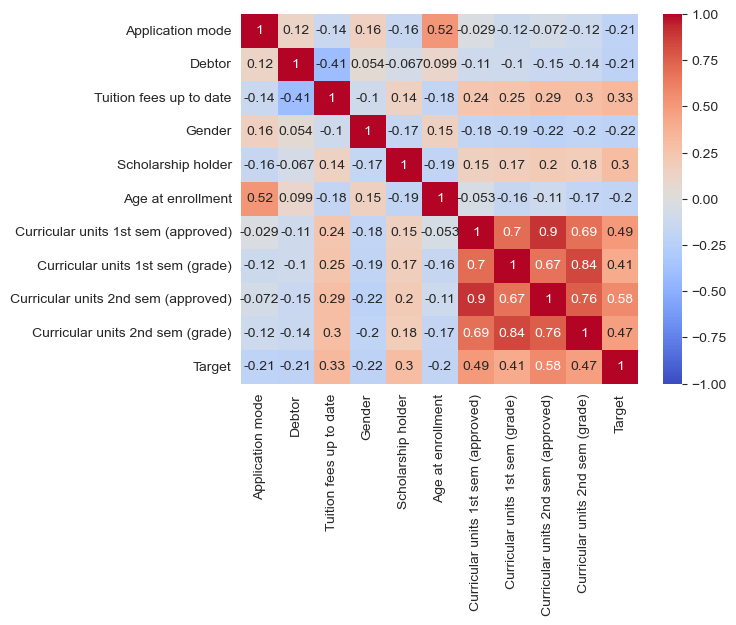

In [543]:
# First reduce the number of features to 10 using the Chi Square method
selected_features = select_feature_chi2(10, 0)
df_selected_features = df[selected_features.tolist() + ['Target']]
mapping = {'Dropout': 1, 'Enrolled': 1, 'Graduate': 3}
df_selected_features['Target'] = df_selected_features['Target'].replace(mapping)

sns.heatmap(df_selected_features.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')

some interpretation here...

# Find Most Significant Features

## Chi Square 
we want to find the most significant features, the less the better, while keeping the accuracy 70%+

### NN Model

Import and process data

Function that reports the significant features

In [ ]:
X = df.drop(columns='Target')
y = df['Target']

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data = X_rescaled, columns = X.columns)

NN Model function

In [506]:
def NN_Model_less_Feature(ar_selected_features):
    df_NN = df.copy()
    X = df_NN[ar_selected_features]
    y = df_NN['Target']

    # normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_rescaled = scaler.fit_transform(X)
    X = pd.DataFrame(data = X_rescaled, columns = X.columns)

    categories = [['Enrolled', 'Graduate', 'Dropout']]
    encoder = OneHotEncoder(categories=categories, sparse_output=False)
    y = encoder.fit_transform(y.values.reshape(-1,1))

    data_train, data_test, class_train, class_test = train_test_split(X, y, test_size=0.2)

    mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.4, batch_size = 100, hidden_layer_sizes = (23, 17, 12), max_iter = 500)
    mlp.fit(data_train, class_train)
    pred = mlp.predict(data_test)

    print("Accuracy : ", accuracy_score(class_test, pred))

For loop to try different sets of features on NN Model

In [507]:
# from tqdm import tqdm
for i in range(X.columns.size - 20, 0, -2):
    selector = SelectKBest(chi2, k=i)
    X_selected = selector.fit_transform(X_rescaled, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X.columns[selected_indices]
    print(f'{i} features selected:')
    NN_Model_less_Feature(selected_features)


16 features selected:
Accuracy :  0.7028248587570621
14 features selected:
Accuracy :  0.6768361581920904
12 features selected:
Accuracy :  0.7028248587570621
10 features selected:
Accuracy :  0.7141242937853107
8 features selected:
Accuracy :  0.7107344632768362
6 features selected:
Accuracy :  0.6576271186440678
4 features selected:
Accuracy :  0.6519774011299435
2 features selected:
Accuracy :  0.2542372881355932


we found that 8 features give accuracy 70.97%, which is good. Let's see what are them.

In [508]:
select_feature_chi2(8)

Top 8 significant features:
['Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']


### SVM Model

In [509]:

def SVM_Model_less_Features(ar_selected_features):
    # X = df[ar_selected_features]
    # y = df['Target']
    columns = ar_selected_features.tolist()
    columns.append('Target')
    df_svm = df[columns]
    df_svm = pd.get_dummies(df_svm, columns=ar_selected_features)
    # df_svm = df_svm.astype(int)

    svm_train, svm_test = train_test_split(df_svm, test_size=0.2)

    X_svm_train, y_svm_train = svm_train.drop(columns=['Target']), svm_train['Target']
    X_svm_test, y_svm_test = svm_test.drop(columns=['Target']), svm_test['Target']

    scaler = preprocessing.StandardScaler()
    scaler.fit(X_svm_train)
    Z_svm_train = scaler.transform(X_svm_train)
    Z_svm_test = scaler.transform(X_svm_test)

    svm_li = SVC(kernel='linear')
    svm_li.fit(Z_svm_train, np.asarray(y_svm_train))
    y_pred_li = svm_li.predict(Z_svm_test)
    print('Linear Kernel')
    print("Accuracy : ", accuracy_score(y_svm_test, y_pred_li))


    svc_rbf = SVC(kernel='rbf')
    svc_rbf.fit(Z_svm_train, np.asarray(y_svm_train))
    y_pred_rbf = svc_rbf.predict(Z_svm_test)
    print('RBF Kernel')
    print("Accuracy : ", accuracy_score(y_svm_test, y_pred_rbf))

Note this chunk of code takes ages (4mins, and the accuracy varies randomly, but the result that 4 features are sufficient to predict is consistent)

In [514]:
for i in range(X.columns.size -26, 0, -1): # since SVM takes more time to train, we start with even less features than NN Model 
    selector = SelectKBest(chi2, k=i)
    X_selected = selector.fit_transform(X_rescaled, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X.columns[selected_indices]
    print(f'{i} features selected:')
    SVM_Model_less_Features(selected_features)
    print()

10 features selected:
Linear Kernel
Accuracy :  0.672316384180791
RBF Kernel
Accuracy :  0.7265536723163842

9 features selected:
Linear Kernel
Accuracy :  0.7163841807909604
RBF Kernel
Accuracy :  0.7378531073446327

8 features selected:
Linear Kernel
Accuracy :  0.7209039548022599
RBF Kernel
Accuracy :  0.7401129943502824

7 features selected:
Linear Kernel
Accuracy :  0.711864406779661
RBF Kernel
Accuracy :  0.7231638418079096

6 features selected:
Linear Kernel
Accuracy :  0.7016949152542373
RBF Kernel
Accuracy :  0.7050847457627119

5 features selected:
Linear Kernel
Accuracy :  0.6836158192090396
RBF Kernel
Accuracy :  0.6768361581920904

4 features selected:
Linear Kernel
Accuracy :  0.7231638418079096
RBF Kernel
Accuracy :  0.7084745762711865

3 features selected:
Linear Kernel
Accuracy :  0.6779661016949152
RBF Kernel
Accuracy :  0.6734463276836158

2 features selected:
Linear Kernel
Accuracy :  0.5163841807909605
RBF Kernel
Accuracy :  0.5209039548022599

1 features selected:

SVM with __Linear__ kernel gives 72.32% accuracy with only `4` features. Lets see what are them.

we can also observe a significant drop in terms of accuracy from 4 features to 3 features (70% ish to <68%)

In [472]:
select_feature_chi2(4)

Top 4 significant features:
['Debtor', 'Scholarship holder', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']


## Decision Tree Classifier

In [475]:

def Deci_Tree_less_Features(ar_selected_features):
    columns = ar_selected_features.tolist()
    columns = columns + ['Target']
    df_DTC = df[columns]
    
    train, test = train_test_split(df_DTC, test_size=0.2)

    X_train, y_train = train.drop(columns=['Target']), train['Target']
    X_test, y_test = test.drop(columns=['Target']), test['Target']


    clf = DecisionTreeClassifier(random_state=1234)
    dtree_model = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy : ", accuracy_score(y_test, y_pred))



In [479]:
for i in range(X.columns.size - 20, 0, -2): # since SVM takes more time to train, we start with even less features than NN Model 
    selector = SelectKBest(chi2, k=i)
    X_selected = selector.fit_transform(X_rescaled, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X.columns[selected_indices]
    print(f'{i} features selected:')
    Deci_Tree_less_Features(selected_features)
    print()

16 features selected:
Accuracy :  0.6734463276836158

14 features selected:
Accuracy :  0.6485875706214689

12 features selected:
Accuracy :  0.6361581920903955

10 features selected:
Accuracy :  0.63954802259887

8 features selected:
Accuracy :  0.6576271186440678

6 features selected:
Accuracy :  0.6384180790960452

4 features selected:
Accuracy :  0.6790960451977401

2 features selected:
Accuracy :  0.5559322033898305



Decision Tree Classifer doesn't have a good performance on this dataset.

### Random Forest Classifer

In [481]:
from sklearn.ensemble import RandomForestClassifier

def Random_forest_less_Features(ar_selected_features):
    columns = ar_selected_features.tolist()
    columns = columns + ['Target']
    df_RDC = df[columns]
    
    train, test = train_test_split(df_RDC, test_size=0.2)

    X_train, y_train = train.drop(columns=['Target']), train['Target']
    X_test, y_test = test.drop(columns=['Target']), test['Target']

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)
    print("Accuracy : ", accuracy_score(y_test, y_pred))
    

In [486]:
for i in range(X.columns.size - 25, 0, -1): 
    selector = SelectKBest(chi2, k=i)
    X_selected = selector.fit_transform(X_rescaled, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = X.columns[selected_indices]
    print(f'{i} features selected:')
    Random_forest_less_Features(selected_features)
    print()

11 features selected:
Accuracy :  0.727683615819209

10 features selected:
Accuracy :  0.7333333333333333

9 features selected:
Accuracy :  0.7468926553672316

8 features selected:
Accuracy :  0.7254237288135593

7 features selected:
Accuracy :  0.7016949152542373

6 features selected:
Accuracy :  0.6858757062146893

5 features selected:
Accuracy :  0.6745762711864407

4 features selected:
Accuracy :  0.6813559322033899

3 features selected:
Accuracy :  0.6440677966101694

2 features selected:
Accuracy :  0.5559322033898305

1 features selected:
Accuracy :  0.519774011299435



7 Features give 70.17% accuracy, but SVM is better(only 4 features)

### Conclusion

SVM with `linear` Model using the least number of features (4) and maintains the accuracy 70%+. So lets explore more...

In [515]:


def report_confusion_matrices_and_other_measurement(ar_class_test, ar_pred):
    print("Accuracy : ", accuracy_score(ar_class_test, ar_pred))
    mcm =  multilabel_confusion_matrix(ar_class_test, ar_pred)
    categories = [['Enrolled', 'Graduate', 'Dropout']]
    unique_labels = categories[0]
    for i, label in enumerate(unique_labels):
        print(f"Confusion Matrix for label '{label}':")
        cm = mcm[i]
        print(cm)
        tp = cm[1, 1]
        fn = cm[1, 0]
        fp = cm[0, 1]
        tn = cm[0, 0]
        
        print(f"True Positive (TP)  : {tp}")
        print(f"False Negative (FN) : {fn}")
        print(f"False Positive (FP) : {fp}")
        print(f"True Negative (TN)  : {tn}")
        print()
    
   # print("Mean Square Error : ", mean_squared_error(ar_class_test, ar_pred))
    print("Classification Report : ")
    print(classification_report(ar_class_test, ar_pred))
    




In [523]:

def SVM_Model_less_Features_with_report(ar_selected_features):
    # X = df[ar_selected_features]
    # y = df['Target']
    columns = ar_selected_features.tolist()
    columns.append('Target')
    df_svm = df[columns]
    df_svm = pd.get_dummies(df_svm, columns=ar_selected_features)
    # df_svm = df_svm.astype(int)

    svm_train, svm_test = train_test_split(df_svm, test_size=0.2)

    X_svm_train, y_svm_train = svm_train.drop(columns=['Target']), svm_train['Target']
    X_svm_test, y_svm_test = svm_test.drop(columns=['Target']), svm_test['Target']

    scaler = preprocessing.StandardScaler()
    scaler.fit(X_svm_train)
    Z_svm_train = scaler.transform(X_svm_train)
    Z_svm_test = scaler.transform(X_svm_test)

    svm_li = SVC(kernel='linear')
    svm_li.fit(Z_svm_train, np.asarray(y_svm_train))
    y_pred_li = svm_li.predict(Z_svm_test)
    print('Linear Kernel')
    report_confusion_matrices_and_other_measurement(y_svm_test, y_pred_li)

    svc_rbf = SVC(kernel='rbf')
    svc_rbf.fit(Z_svm_train, np.asarray(y_svm_train))
    y_pred_rbf = svc_rbf.predict(Z_svm_test)
    print('RBF Kernel')
    report_confusion_matrices_and_other_measurement(y_svm_test, y_pred_rbf)


In [525]:
selected_features = select_feature_chi2(4)
SVM_Model_less_Features_with_report(selected_features)

Top 4 significant features:
['Debtor', 'Scholarship holder', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']
Linear Kernel
Accuracy :  0.7129943502824859
Confusion Matrix for label 'Enrolled':
[[554  54]
 [ 79 198]]
True Positive (TP)  : 198
False Negative (FN) : 79
False Positive (FP) : 54
True Negative (TN)  : 554

Confusion Matrix for label 'Graduate':
[[631  83]
 [111  60]]
True Positive (TP)  : 60
False Negative (FN) : 111
False Positive (FP) : 83
True Negative (TN)  : 631

Confusion Matrix for label 'Dropout':
[[331 117]
 [ 64 373]]
True Positive (TP)  : 373
False Negative (FN) : 64
False Positive (FP) : 117
True Negative (TN)  : 331

Classification Report : 
              precision    recall  f1-score   support

     Dropout       0.79      0.71      0.75       277
    Enrolled       0.42      0.35      0.38       171
    Graduate       0.76      0.85      0.80       437

    accuracy                           0.71       885
   macro avg       0.66    

need some interpretations...